# Recurrent Neural Networks on Stock Prediction v2

Thesis: NN can better identify patterns within the stock market, because they are able to analyse data at dimensions higher than 3 very easily. People are only able to perceive up to 3 dimensions, which limits our ability to identify patterns within a multi-dimensional data set

Practice: Build a RNN for a single stock. See if it can identify whether a stock will rise by 1% within 5 days.

Steps:
- Check if other stock characteristics are important (industry, business model, volatility, etc.)
- Expand to include multiple day windows (3 days, 10 days, 1 day, etc.) See if predictions are more accurate for these multiple windows
- Expand to include multiple buffers (2%, 5%, 10%, etc.). 
    - Note: Of course a 10% rise in 5 days is very unlikely, but perhaps the model is able to predict these flags with higher precision?

In [1]:
# Import the required packages

import numpy as np
from numpy import array, argmax

import pandas as pd
from pandas import DataFrame
from pandas_datareader import data

import matplotlib.pyplot as plt
from matplotlib import style

from datetime import datetime

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, LSTM
from keras.utils import to_categorical, plot_model

from sklearn.preprocessing import OneHotEncoder, LabelEncoder

import time

from colour import Color

import missingno as msno

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


The model:

I'm going to build a Long-Short Term Memory Neural Network.

The data:
Each data sample will represent `p` days previous of trading information (OHLC) for a particular stock. The model will predict whether the stock will be able to go up `target`% within `window` number days.

For now, we'll set the following hyperparameters:

In [2]:
# Set our hyperparameter variables

# For now we'll just pick one stock. Later, I'll want to add a list of multiple stocks
stockNames = ["GE", "MA", "MSFT", "DIS"] # Sample stock to play with
target = .01     # Target to identify if stock increased by 1%
window = 5       # Window to identify whether stock hit target within these number of days
p = 90           # number of days of data for each data point

# The features we'll include in X to inform the model
features = ["oh_pct", "ol_pct", "oc_pct", "co_pct", "cc_pct"]

In [3]:
# Load the OHLC data into the variable data
data_source = 'morningstar'
start_date = datetime(2010, 1, 1)
end_date = datetime(2018, 3, 2)

# Measure how long it takes to load the data 
startTime = time.time()

# Load the data
base_data = data.DataReader(stockNames, data_source, start_date, end_date)
column_labels = base_data.columns
print("Loading data for {} stocks took {:3.1f} seconds".format(len(stockNames), time.time()-startTime))

# Sort the data by date so that we can reference slices of the date index later
base_data.sort_index(level=[0], axis=0, inplace=True)

Loading data for 4 stocks took 18.0 seconds


In [4]:
# Export the base_data to CSV so we can check the data transformations

base_data.to_csv("base_data.csv")

In [5]:
# Here's a summary of what our data looks like. 
print("Here's a summary of our table:")
display(base_data.describe())
print("Here's what the first few rows of what {} looks like".format(stockNames[0]))
display(base_data.head())

Here's a summary of our table:


,Close,High,Low,Open,Volume
count,8524.00000,8524.000000,8524.000000,8524.000000,8.524000e+03
mean,52.41647,52.807143,51.992888,52.402731,2.611537e+07
std,32.57289,32.770625,32.355952,32.566249,2.800132e+07
min,13.88000,14.240000,13.750000,13.990000,0.000000e+00
25%,26.55000,26.743750,26.340000,26.557500,6.377135e+06
50%,39.91000,40.179500,39.565000,39.900000,1.660667e+07
75%,76.40000,76.930000,75.900000,76.482500,3.841560e+07
max,177.87000,179.170000,176.060000,177.720000,4.313160e+08


Here's what the first few rows of what GE looks like


Close   High    Low   Open    Volume
Symbol Date                                            
DIS    2010-01-01  32.25  32.75  32.22  32.27         0
       2010-01-04  32.07  32.75  31.87  32.50  13700385
       2010-01-05  31.99  32.16  31.70  32.07  10307697
       2010-01-06  31.82  32.00  31.68  31.90  10709499
       2010-01-07  31.83  31.86  31.54  31.77   8202059

In [6]:
# Create variables for creating flag column
def get_trading_days(base_data):
    stockNames = base_data.index.levels[0].values
    trading_days = {}
    for stock in stockNames:
        trading_days[stock] = base_data.loc[stock].shape[0]
    return trading_days

Next, we'll want to create a flag for each day. The flag will indicate whether our stock price will hit the price `target` within `window` days.

In [7]:
def create_is_sellable_flag(base_data, window = 5, target = 0.01):
    # Identify the stocks within the base_data
    stockNames = base_data.index.levels[0].values
    
    # Identify the number of trading days uploaded for each stock
    trading_days = get_trading_days(base_data)
    
    # Check if a "is_sellable" column already exists. If so, delete it
    if "is_sellable" in base_data.columns:
        base_data.drop(labels="is_sellable", axis=1, inplace=True)
    
    open_price = base_data.Open
    high = base_data.High
    
    # Create a `is_sellable` flag column filled with 0s
    is_sellable = pd.Series(0, index=base_data.index, name="is_sellable")

    startTime = time.time()
    #TODO: Vectorize this part. It takes a long time to run.
    # For loop to add the column with flags to identify if stock will hit target within window
    for stock in stockNames:
        index = 0
        for indexDate in base_data.loc[stock].index:
            endIndex = min(index + window, trading_days[stock]-1)
            
            # We take the endIndex - 1 because when slicing the dates 
            # for high_window below, the slice takes both the start and end times inclusive.
            endDate = base_data.loc[stock].index[endIndex-1]
            high_window = high.loc[stock,indexDate:endDate]

            # If high price within the high_window is greater than target price, set is_sellable to 1
            if (high_window > open_price.loc[stock,indexDate] * (1+target)).any():
                is_sellable.loc[stock, indexDate] = 1
            index += 1

    # Add is_sellable column to the data variable
    print("Creating is_sellable column took {:3.1f} seconds".format(time.time()-startTime))
    base_data = pd.concat((base_data, is_sellable), axis=1)
    
    return base_data

In [8]:
# Create the is_sellable flag column
base_data = create_is_sellable_flag(base_data, window=window, target=target)

Creating is_sellable column took 24.2 seconds


In [9]:
def normalize_prices(base_data):
    
    # Normalize data by creating columns showing price relation to Open price. Create 4 columns:
    # 1) oh_pct = High / Open
    # 2) ol_pct = Low / Open
    # 3) oc_pct = Close / Open
    # 4) co_pct = Open / Close(t-1)
    # 5) cc_pct = Close / Close(t-1)
    
    # Track how long it takes to do this. Performance affected by for loop.
    startTime = time.time()
    
    # Identify the stocks within the base_data
    stockNames = base_data.index.levels[0].values
    
    # Identify the number of trading days uploaded for each stock
    trading_days = get_trading_days(base_data)
    
    # Check if these columns already exist. If so, delete them
    for col in base_data.columns:
        if col in features:
            base_data.drop(labels=col, axis=1, inplace=True)
    
    # Create the new normalized columns
    oh_pct = base_data.High / base_data.Open - 1
    ol_pct = base_data.Low / base_data.Open - 1
    oc_pct = base_data.Close / base_data.Open - 1
    
    # Name the new columns, so they have a header in the table
    oh_pct.name = "oh_pct"
    ol_pct.name = "ol_pct"
    oc_pct.name = "oc_pct"
    
    # Need to run these on a foor loop because they look back 1 day
    co_pct = pd.Series(0., index=base_data.index, name="co_pct")
    cc_pct = pd.Series(0., index=base_data.index, name="cc_pct")
    
    for stock in stockNames:
        for i in np.arange(trading_days[stock]):
            if i != 0:
                co_pct.loc[stock].iloc[i] = base_data.Open.loc[stock].iloc[i] / base_data.Close.loc[stock].iloc[i-1] - 1
                cc_pct.loc[stock].iloc[i] = base_data.Close.loc[stock].iloc[i] / base_data.Close.loc[stock].iloc[i-1] - 1
    base_data = pd.concat((base_data, oh_pct, ol_pct, oc_pct, co_pct, cc_pct), axis=1)
    print("Creating these columns for {} stocks took {:3.1f} seconds".format(len(stockNames), time.time()-startTime))
    return base_data

In [10]:
# Create columns with % change in prices, instead of raw price numbers
base_data = normalize_prices(base_data)
base_data.to_csv("normalized.csv")

Creating these columns for 4 stocks took 22.4 seconds


In [11]:
def remove_stock_prices(base_data):
    col_to_remove = ["Close", "High", "Low", "Open", "Volume"]
    for col in col_to_remove:
        if col in base_data.columns:
            base_data.drop(col, axis=1, inplace=True)
    return base_data

In [12]:
# We'll also have to remove the original stock prices
base_data = remove_stock_prices(base_data)

In [13]:
def print_graphs(base_data, ncols = 3):

    # Displays graphs showing the stock data
    
    # Identify the stocks within the base_data
    stockNames = base_data.index.levels[0].values
    
    # Identify the number of trading days uploaded for each stock
    trading_days = get_trading_days(base_data)
    
    # Identify which stock has the most trading days
    longest_stock = max(trading_days)
    max_time_index = base_data.loc[longest_stock].index
    x = max_time_index
    
    # Setup a few variables for creating the graphs
    nrows = int(np.ceil(len(stockNames)/ncols))
    figsize = (4*ncols,4*nrows)
    ax = np.zeros((nrows, ncols))

    # Choose which colors to use for each line
    beg_color = Color("red")
    end_color = Color("blue")
    increasing_colors = list(beg_color.range_to(end_color,len(features)))
    
    # Create instances for the figure and all of the subplots within the figure
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex='all', sharey='all', figsize=figsize, squeeze = False)
    for i in range(nrows):
        for j in range(ncols):

            # Pick each stock based on location within the nrows x ncols figure
            stockIndex = i*ncols + j
            if stockIndex < len(stockNames):
                ax[i,j].set_title(stockNames[stockIndex])
                for k, line in enumerate(features):

                    # Initialize the y variable with max_time_index
                    y = pd.Series(None, index=max_time_index)
                    y.update(base_data.loc[stockNames[stockIndex], line]) 
                    # Plot the line
                    lined = ax[i,j].plot(x, y, color=increasing_colors[k].rgb)
    fig.legend(lined, ('Line 1'), 'upper left')
    fig.tight_layout()
    plt.show()

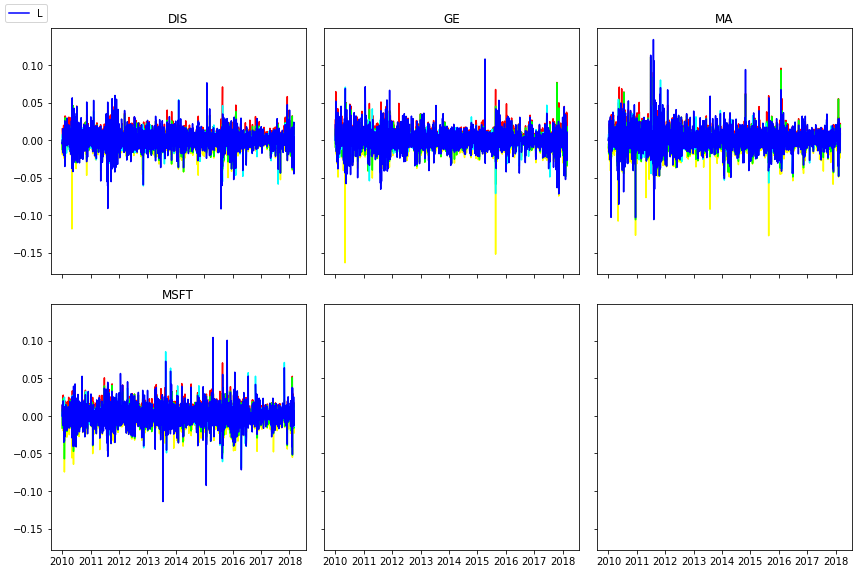

In [14]:
# Here's the data tables look like now.
print_graphs(base_data)

In [15]:
def standardize(base_data):
    
    # Note: This standardizes across all stock data, not for each individual stock.
    
    # Cycle through each column in the database and standardize each column
    for col in base_data.columns:
        
        # Don't standardize the "is_sellable" column
        if col != "is_sellable":
            mean = base_data.loc[:, col].mean()
            stddev = base_data.loc[:, col].std()
            base_data.loc[:, col] = (base_data.loc[:, col] - mean) / stddev
    
    return base_data

In [16]:
# We'll need to standardize the data to a Gaussian normal (mean = 0, std dev = 1) to allow the model to train faster
base_data = standardize(base_data)
base_data.to_csv("standardized.csv")

The graphs below show the distribution of each column after standardizing them. Notice that oh_pct and ol_pct don't have the normal distribution shape - that is because by the nature of their data. High prices are always higher than open prices, thus oh_pct is always positive, and ol_pct is always negative.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1ef0ef60>,
      dtype=object)

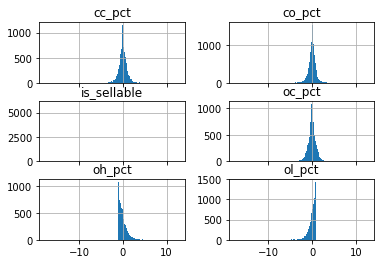

In [17]:
base_data.hist(bins=100, sharex=True)

In [18]:
m = {}
trading_days = get_trading_days(base_data)
for stock in stockNames:
    m[stock] = trading_days[stock] - (p + window) + 1

print(np.arange(m[stock]))
print(trading_days)

[   0    1    2 ... 2034 2035 2036]
{'DIS': 2131, 'GE': 2131, 'MA': 2131, 'MSFT': 2131}


In [19]:
def reshape_for_LSTM(base_data):
    
    # Re-shaping the data set. Each row should represent `window` days 
    # of trading data and the sell flag.

    # We're going to be converting our data from pandas to numpy, 
    # which supports multi-dimensional data much better.
    
    # Track how long it takes to do this. Performance affected by for loop.
    startTime = time.time()
    
    # Identify the stocks within the base_data
    stockNames = base_data.index.levels[0].values
    
    # Identify the number of trading days uploaded for each stock
    trading_days = get_trading_days(base_data)
        
    # Identify the number of data samples we can get for each stock
    m = {}
    trading_days = get_trading_days(base_data)
    for stock in stockNames:
        m[stock] = trading_days[stock] - (p + window) + 1
    
    f = len(features)
    # Intialize the numpy dataset with the right dimensions: (m, p, features)
    # We'll add 1 extra slot onto the 2nd dimension so we can include 
    # the is_sellable column and shuffle the dataset together. 
    # After shuffling, we'll separate out is_sellable as our y variables.
    datanp = np.zeros((sum(m.values()), p + 1, f))   

    # Use i_base so we can count across rows for each stock as well as total rows in datanp
    i_base = 0
    for stock in stockNames:
        for i in np.arange(m[stock]): 
            datanp[i+i_base, :p, :] = base_data.loc[stock, features].iloc[i:i+p].values
            datanp[i+i_base, -1, 0] = base_data.loc[stock, "is_sellable"].iloc[i+p]
        i_base += m[stock]
        
    return datanp

In [20]:
# We'll convert and re-shape the base_data into a suitable format for our LSTM model.
# The data will be re-shaped to have shape (m, p+1, # of features)
# m is the number of data samples we'll have. Because we're looking at a 
# history of days size `p`, with a look forward of `window`, our final m count will be
# m = trading_days[stock] - (p + w) + 1

datanp = reshape_for_LSTM(base_data)

In [21]:
# Add a number index to 3 dimension, index 1 so that we can review what the data looks like.
# This column won't be copied over to X and Y anyways.
datanp[:,-1,1] = np.arange(datanp.shape[0])
for col in np.arange(datanp.shape[2]):
    np.savetxt("index"+str(col)+".csv", datanp[:,:,col], fmt='%.3f', delimiter=",")

In [22]:
# We need to shuffle the data in order to train the model well.
# Otherwise we introduce unnecessary bias.
#np.random.shuffle(datanp)
#for col in np.arange(datanp.shape[2]):
#    np.savetxt("shuffle"+str(col)+".csv", datanp[:,:,col], fmt='%.3f', delimiter=",")

In [23]:
# Now we'll separate out the X data from the Y data
X = datanp[:, :p, :]
Y = datanp[:, -1, 0]

We'll need to split our data set into a training and test set.

In [24]:
# Split our data set into train/test sets based on split %.
pct_train = .95
pct_test = 1 - pct_train

In [25]:
# Index of separation points within the index
train_test_idx_num = int(pct_train * X.shape[0])

# Split the data as per proportions above
X_train = X[:train_test_idx_num, :, :]
Y_train = Y[:train_test_idx_num]

X_test = X[train_test_idx_num:, :, :]
Y_test = Y[train_test_idx_num:]

In [26]:
# This is what the dimensions look like
display("Shape of X_train: {}".format(X_train.shape))
display("Shape of Y_train: {}".format(Y_train.shape))
display("Shape of X_test: {}".format(X_test.shape))
display("Shape of Y_test: {}".format(Y_test.shape))

'Shape of X_train: (7740, 90, 5)'

'Shape of Y_train: (7740,)'

'Shape of X_test: (408, 90, 5)'

'Shape of Y_test: (408,)'

Now we'll begin building our model.

In [27]:
# Function for setting up the model architecture

def model_setup_2_layers():

    model = Sequential()
    model.add(LSTM(input_shape = (X_train.shape[1], X_train.shape[2]), units = 50, return_sequences = True))
    model.add(Activation("relu"))
    model.add(Dropout(0.2))

    model.add(LSTM(100, return_sequences = False))
    model.add(Activation("relu"))
    model.add(Dropout(0.2))

    model.add(Dense(1, activation="sigmoid"))
    
    return model

In [28]:
# Create a 2 layer model, and see how it performs.
model = model_setup_2_layers()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 90, 50)            11200     
_________________________________________________________________
activation_1 (Activation)    (None, 90, 50)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 90, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               60400     
_________________________________________________________________
activation_2 (Activation)    (None, 100)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total para

In [29]:
# Definition for training the model
def train_model(model, epochs, batch_size):
    start = time.time()
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    print ('Model compilation time : ', time.time() - start)
    history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size)
    print ('Model fit time : ', time.time() - start)
    
    return model, history

In [30]:
# Train the model

# The number of times we'll run our entire data set through the model to train it
epochs = 50

# Batch size is the number of X samples that will run through for each iteration. 
# Usually we just pick a number between 1 and m to speed up training.
batch_size = 32

# Train the model (using my custom function)
model, history = train_model(model, epochs = epochs, batch_size = batch_size)

Model compilation time :  0.0636138916015625
Epoch 1/50
7740/7740 [==============================] - 43s 6ms/step - loss: 0.6116 - acc: 0.6908
Epoch 2/50
7740/7740 [==============================] - 45s 6ms/step - loss: 0.6033 - acc: 0.6911
Epoch 3/50
7740/7740 [==============================] - 41s 5ms/step - loss: 0.6023 - acc: 0.6915
Epoch 4/50
7740/7740 [==============================] - 40s 5ms/step - loss: 0.6017 - acc: 0.6916
Epoch 5/50
7740/7740 [==============================] - 39s 5ms/step - loss: 0.5994 - acc: 0.6937
Epoch 6/50
7740/7740 [==============================] - 40s 5ms/step - loss: 0.5985 - acc: 0.6939
Epoch 7/50
7740/7740 [==============================] - 46s 6ms/step - loss: 0.5969 - acc: 0.6920
Epoch 8/50
7740/7740 [==============================] - 48s 6ms/step - loss: 0.5960 - acc: 0.6963
Epoch 9/50
7740/7740 [==============================] - 46s 6ms/step - loss: 0.5906 - acc: 0.6943
Epoch 10/50
7740/7740 [==============================] - 45s 6ms/step - l

In [32]:
def plot_loss(history, dev_set = False):
    
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    if dev_set == True:
        plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    # summarize history for loss
    plt.plot(history.history['loss'])
    if dev_set == True:
        plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

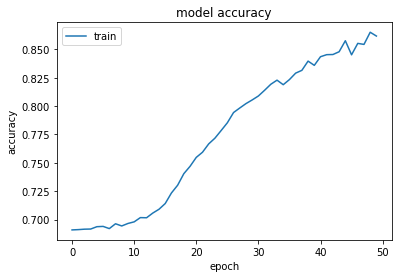

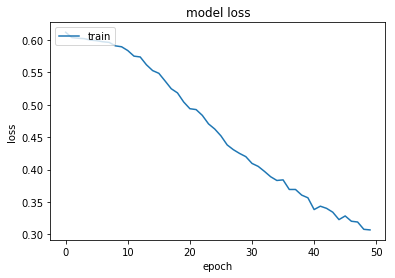

In [33]:
# Plot the loss and accuracy functions
plot_loss(history)

In [34]:
# Evaluate the model with our test set
score = model.evaluate(X_test, Y_test, batch_size=128)
print("Baseline average of Y:    {:3.1f}%".format(np.average(Y)*100))
print("Y_test prediction:        {:3.1f}%".format(score[1]*100))

408/408 [==============================] - 1s 2ms/step
Baseline average of Y:    69.0%
Y_test prediction:        56.6%


Looks like for the mixture of stocks, this model didn't improve predictions at all!

Further investigations:
- Review for any other journals on RNN models on stock data
- Check other ML models - what did they do? What did they include? What did they not include? And why?
- Do we need to add some drop out blocks? Drop out blocks help with regularization. But given that there is so much noise in stock data, is this required?
- Do I need to further update the data so that it's not just raw prices, but daily changes, volumes, distance, etc.?

This research was inspired by the following papers:
- https://pdfs.semanticscholar.org/6ea2/b0f7f9de845790d9add00a0a103f9d3242b5.pdf